In [1]:
# Import Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import tarfile
import re
import copy
import pickle
import argparse
import os.path
import sys
import time
import gzip
import configparser
import csv
import numpy as np

In [3]:
def load_data_mnist(dataset):
    f = gzip.open(dataset, 'rb')
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
    f.close()

    n_in = 28
    in_channel = 1

    test_set_x, test_set_y = test_set
    valid_set_x, valid_set_y = valid_set
    train_set_x, train_set_y = train_set

    rval = [(train_set_x, train_set_y), (valid_set_x, valid_set_y), (test_set_x, test_set_y)]
    return rval, n_in, in_channel, 10


def load_data_cifar10(dataset):
    train_dic = dict()
    f = tarfile.open(dataset, 'r')
    for member in f.getmembers():
        match1 = re.search(r".*\/data_batch_.*", member.name)
        match2 = re.search(r".*\/test_batch", member.name)
        if match1 is not None:
            print("Training: extracting {} ...".format(member.name))
            ef = f.extractfile(member)
            train_tmp = pickle.load(ef, encoding='latin1')
            if bool(train_dic) is False:
                train_dic = train_tmp
            else:
                train_dic['data'] = np.append(train_dic['data'], train_tmp['data'], axis=0)
                train_dic['labels'] = np.append(train_dic['labels'], train_tmp['labels'], axis=0)
        elif match2 is not None:
            print("Testing/Validating: extracting {} ...".format(member.name))
            ef = f.extractfile(member)
            test_dic = pickle.load(ef, encoding='latin1')
            test_dic['labels'] = np.array(test_dic['labels'])
    f.close()

    n_in = 32
    in_channel = 3

    def shared_dataset(data_dic, borrow=True):
        data_x = data_dic['data'].astype(np.float32)
        data_x /= 255.0#data_x.max()
        data_y = data_dic['labels'].astype(np.int32)
        return data_x, data_y

    train_set_x, train_set_y = shared_dataset(train_dic)
    test_set_x, test_set_y = shared_dataset(test_dic)
    #valid_set_x, valid_set_y = shared_dataset(valid_dic)

    rval = [(train_set_x, train_set_y), (test_set_x, test_set_y), (test_set_x, test_set_y)]
    return rval, n_in, in_channel, 10



In [4]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as N
import matplotlib.pyplot as plt
import os
import numpy as np
input_path = os.path.join('/content/drive/MyDrive','MNIST_data/mnist.pkl.gz')
drive_path = os.path.join('/content/drive/myDrive')

Instructions for updating:
non-resource variables are not supported in the long term


In [5]:
OUTPUT_FOLDER = "output"
EXERCISE = "exercise_2"
OUTPUT_DIR = os.path.join(drive_path, OUTPUT_FOLDER)
# os.makedirs(OUTPUT_DIR, exist_ok=True)

In [6]:
# Read data from file
data_input = load_data_mnist(input_path)
data = data_input[0]

# Data layout changes since output should an array of 10 with probabilities
real_output = N.zeros( (N.shape(data[0][1])[0] , 10), dtype=N.float32 )
for i in range ( N.shape(data[0][1])[0] ):
  real_output[i][data[0][1][i]] = 1.0

# Data layout changes since output should an array of 10 with probabilities
real_check = N.zeros( (N.shape(data[2][1])[0] , 10), dtype=N.float32 )
for i in range ( N.shape(data[2][1])[0] ):
  real_check[i][data[2][1][i]] = 1.0

# Set up the computation. Definition of the variables.
x = tf.placeholder(tf.float32, [None, 784])
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))
y = tf.nn.softmax(tf.matmul(x, W) + b)
y_ = tf.placeholder(tf.float32, [None, 10])

cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))


In [10]:
N_EPOCHS = 100
ls_optimizer = [tf.train.GradientDescentOptimizer(0.5),
                 tf.train.MomentumOptimizer(0.1, 0.8),
                 tf.train.AdamOptimizer(0.001)]

TRAINING
EPOCH 0(100) -- OPT: GradientDescentOptimizer -- Loss: 0.3276244103908539 --- ACC: 0.9078999757766724
EPOCH 1(100) -- OPT: GradientDescentOptimizer -- Loss: 0.3038523495197296 --- ACC: 0.9144999980926514
EPOCH 2(100) -- OPT: GradientDescentOptimizer -- Loss: 0.29309457540512085 --- ACC: 0.9157000184059143
EPOCH 3(100) -- OPT: GradientDescentOptimizer -- Loss: 0.2865545451641083 --- ACC: 0.9164999723434448
EPOCH 4(100) -- OPT: GradientDescentOptimizer -- Loss: 0.28198909759521484 --- ACC: 0.9168999791145325
EPOCH 5(100) -- OPT: GradientDescentOptimizer -- Loss: 0.27853116393089294 --- ACC: 0.9171000123023987
EPOCH 6(100) -- OPT: GradientDescentOptimizer -- Loss: 0.275767058134079 --- ACC: 0.9172000288963318
EPOCH 7(100) -- OPT: GradientDescentOptimizer -- Loss: 0.2734725773334503 --- ACC: 0.9169999957084656
EPOCH 8(100) -- OPT: GradientDescentOptimizer -- Loss: 0.2715148329734802 --- ACC: 0.9175999760627747
EPOCH 9(100) -- OPT: GradientDescentOptimizer -- Loss: 0.26980960369110

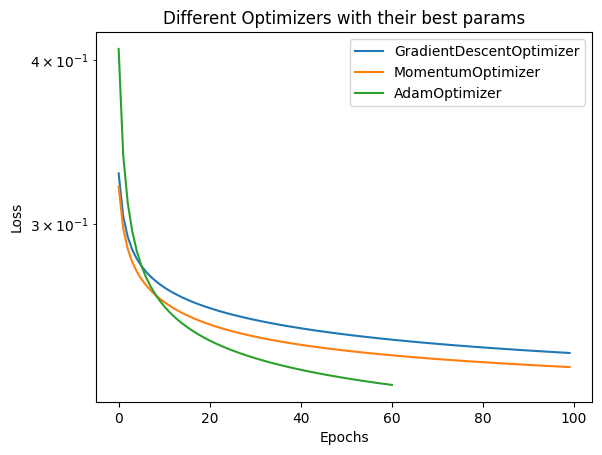

In [11]:
for optimizer in ls_optimizer:

  with tf.device('/gpu:0'):
    train_step = optimizer.minimize(cross_entropy)

    sess = tf.InteractiveSession()
    tf.global_variables_initializer().run()

    #TRAINING PHASE
    print("TRAINING")

    ls_loss = []
    ls_acc = []
    for epoch in range(N_EPOCHS):
      for i in range(500):
        batch_xs = data[0][0][100*i:100*i+100]
        batch_ys = real_output[100*i:100*i+100]
        sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

      #CALCULATING THE LOSS
      loss = sess.run(cross_entropy, feed_dict={x: data[0][0], y_: real_output})

      #CHECKING THE ERROR
      # print("ERROR CHECK")

      correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
      accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
      ACC = sess.run(accuracy, feed_dict={x: data[2][0], y_: real_check})
      print(f"EPOCH {epoch}({N_EPOCHS}) -- OPT: {optimizer.__class__.__name__} -- Loss: {loss} --- ACC: {ACC}")

      ls_loss.append(loss)
    ls_acc.append(ACC)

  plt.plot(range(N_EPOCHS), ls_loss, label=f"{optimizer.__class__.__name__}")
  # Use log scale to better visualize the loss
  plt.yscale("log")

plt.legend()
plt.title("Different Optimizers with their best params")
plt.xlabel("Epochs")
plt.ylabel("Loss")
filename = "single_layer_multioptimizer.png"

plt.savefig(filename, bbox_inches="tight");